<a href="https://colab.research.google.com/github/Anandharajan/CWT/blob/main/timeforeIntern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima


In [9]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from fbprophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

myfavouritenumber = 13
seed = myfavouritenumber
np.random.seed(seed)

In [12]:
import glob
import os
import pandas as pd   
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('/content', "*.csv"))))

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182606 entries, 0 to 13734
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Symbol                          182592 non-null  object 
 1   Trade Type                      182592 non-null  object 
 2   Entry DateTime                  182592 non-null  object 
 3   Exit DateTime                   182592 non-null  object 
 4   Entry Price                     182592 non-null  float64
 5   Exit Price                      182592 non-null  float64
 6   Trade Quantity                  182592 non-null  float64
 7   Max Open Quantity               182592 non-null  float64
 8   Max Closed Quantity             182592 non-null  float64
 9   Profit/Loss (C)                 182606 non-null  object 
 10  Cumulative Profit/Loss (C)      182592 non-null  float64
 11  Duration                        182592 non-null  object 
 12  High Price While 

In [20]:
data = df[['Entry DateTime','High Price While Open','Exit Price', 'Cumulative Profit/Loss (C)']]
data.head()

,Entry DateTime,High Price While Open,Exit Price,Cumulative Profit/Loss (C)
0,2016-01-03 22:27:04.015 BP,1064.0,1063.9,-128.4
1,2016-01-04 01:07:03.003 BP,1068.5,1068.5,-236.8
2,2016-01-04 03:09:32.003 BP,1072.6,1072.5,-31.0
3,09:32.0,1074.2,1071.2,44.8
4,2016-01-04 11:49:23.045 BP,1074.1,1074.0,240.6


In [21]:
data['Entry DateTime'] = pd.to_datetime(data['Entry DateTime'], errors='coerce')
data = data.dropna(subset=['Entry DateTime'])

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning:

tzname BP identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153190 entries, 0 to 13733
Data columns (total 4 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Entry DateTime              153190 non-null  datetime64[ns]
 1   High Price While Open       153190 non-null  float64       
 2   Exit Price                  153190 non-null  float64       
 3   Cumulative Profit/Loss (C)  153190 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 5.8 MB


In [23]:
data

,Entry DateTime,High Price While Open,Exit Price,Cumulative Profit/Loss (C)
0,2016-01-03 22:27:04.015,1064.0,1063.9,-128.40
1,2016-01-04 01:07:03.003,1068.5,1068.5,-236.80
2,2016-01-04 03:09:32.003,1072.6,1072.5,-31.00
3,2021-07-29 09:32:00.000,1074.2,1071.2,44.80
4,2016-01-04 11:49:23.045,1074.1,1074.0,240.60
...,...,...,...,...
13728,2021-05-28 11:01:09.908,1899.5,1899.5,-19338.99
13729,2021-07-29 01:09:54.000,1899.7,1896.6,-19533.19
13730,2021-05-28 13:55:57.859,1905.7,1903.4,-19437.39
13732,2021-05-31 02:13:38.890,1910.3,1907.9,-20029.99


In [24]:
data.reset_index(drop=True, inplace=True)
lag_features = ["High Price While Open",	"Exit Price"]
window1 = 3
window2 = 7
window3 = 30

data_rolled_3d = data[lag_features].rolling(window=window1, min_periods=0)
data_rolled_7d = data[lag_features].rolling(window=window2, min_periods=0)
data_rolled_30d = data[lag_features].rolling(window=window3, min_periods=0)

data_mean_3d = data_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
data_mean_7d = data_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
data_mean_30d = data_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

data_std_3d = data_rolled_3d.std().shift(1).reset_index().astype(np.float32)
data_std_7d = data_rolled_7d.std().shift(1).reset_index().astype(np.float32)
data_std_30d = data_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    data[f"{feature}_mean_lag{window1}"] = data_mean_3d[feature]
    data[f"{feature}_mean_lag{window2}"] = data_mean_7d[feature]
    data[f"{feature}_mean_lag{window3}"] = data_mean_30d[feature]
    
    data[f"{feature}_std_lag{window1}"] = data_std_3d[feature]
    data[f"{feature}_std_lag{window2}"] = data_std_7d[feature]
    data[f"{feature}_std_lag{window3}"] = data_std_30d[feature]

data.fillna(data.mean(), inplace=True)

data.set_index("Entry DateTime", drop=False, inplace=True)
data.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,Entry DateTime,High Price While Open,Exit Price,Cumulative Profit/Loss (C),High Price While Open_mean_lag3,High Price While Open_mean_lag7,High Price While Open_mean_lag30,High Price While Open_std_lag3,High Price While Open_std_lag7,High Price While Open_std_lag30,Exit Price_mean_lag3,Exit Price_mean_lag7,Exit Price_mean_lag30,Exit Price_std_lag3,Exit Price_std_lag7,Exit Price_std_lag30
Entry DateTime,,,,,,,,,,,,,,,,
2016-01-03 22:27:04.015,2016-01-03 22:27:04.015,1064.0,1063.9,-128.4,1516.407104,1516.381470,1516.318115,2.980174,4.809142,10.483967,1515.230835,1515.203369,1515.115112,3.041801,4.833632,10.485658
2016-01-04 01:07:03.003,2016-01-04 01:07:03.003,1068.5,1068.5,-236.8,1064.000000,1064.000000,1064.000000,2.980174,4.809142,10.483967,1063.900024,1063.900024,1063.900024,3.041801,4.833632,10.485658
2016-01-04 03:09:32.003,2016-01-04 03:09:32.003,1072.6,1072.5,-31.0,1066.250000,1066.250000,1066.250000,3.181981,3.181981,3.181981,1066.199951,1066.199951,1066.199951,3.252691,3.252691,3.252691
2021-07-29 09:32:00.000,2021-07-29 09:32:00.000,1074.2,1071.2,44.8,1068.366699,1068.366699,1068.366699,4.301550,4.301550,4.301550,1068.300049,1068.300049,1068.300049,4.303487,4.303487,4.303487
2016-01-04 11:49:23.045,2016-01-04 11:49:23.045,1074.1,1074.0,240.6,1071.766724,1069.824951,1069.824951,2.939955,4.565359,4.565359,1070.733276,1069.025024,1069.025024,2.040425,3.801206,3.801206


In [25]:
data["Entry DateTime"] = pd.to_datetime(data["Entry DateTime"], format="%Y-%m-%d")
data["month"] = data["Entry DateTime"].dt.month
data["week"] = data["Entry DateTime"].dt.week
data["day"] = data["Entry DateTime"].dt.day
data["day_of_week"] = data["Entry DateTime"].dt.dayofweek
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Entry DateTime,High Price While Open,Exit Price,Cumulative Profit/Loss (C),High Price While Open_mean_lag3,High Price While Open_mean_lag7,High Price While Open_mean_lag30,High Price While Open_std_lag3,High Price While Open_std_lag7,High Price While Open_std_lag30,Exit Price_mean_lag3,Exit Price_mean_lag7,Exit Price_mean_lag30,Exit Price_std_lag3,Exit Price_std_lag7,Exit Price_std_lag30,month,week,day,day_of_week
Entry DateTime,,,,,,,,,,,,,,,,,,,,
2016-01-03 22:27:04.015,2016-01-03 22:27:04.015,1064.0,1063.9,-128.4,1516.407104,1516.381470,1516.318115,2.980174,4.809142,10.483967,1515.230835,1515.203369,1515.115112,3.041801,4.833632,10.485658,1,53,3,6
2016-01-04 01:07:03.003,2016-01-04 01:07:03.003,1068.5,1068.5,-236.8,1064.000000,1064.000000,1064.000000,2.980174,4.809142,10.483967,1063.900024,1063.900024,1063.900024,3.041801,4.833632,10.485658,1,1,4,0
2016-01-04 03:09:32.003,2016-01-04 03:09:32.003,1072.6,1072.5,-31.0,1066.250000,1066.250000,1066.250000,3.181981,3.181981,3.181981,1066.199951,1066.199951,1066.199951,3.252691,3.252691,3.252691,1,1,4,0
2021-07-29 09:32:00.000,2021-07-29 09:32:00.000,1074.2,1071.2,44.8,1068.366699,1068.366699,1068.366699,4.301550,4.301550,4.301550,1068.300049,1068.300049,1068.300049,4.303487,4.303487,4.303487,7,30,29,3
2016-01-04 11:49:23.045,2016-01-04 11:49:23.045,1074.1,1074.0,240.6,1071.766724,1069.824951,1069.824951,2.939955,4.565359,4.565359,1070.733276,1069.025024,1069.025024,2.040425,3.801206,3.801206,1,1,4,0


In [28]:
data_train = data[data["Entry DateTime"] < "2019"]
data_valid = data[data["Entry DateTime"] >= "2019"]

exogenous_features = ["High Price While Open_mean_lag3", "High Price While Open_mean_lag7",	"High Price While Open_mean_lag30",	"High Price While Open_std_lag3",	
                      "High Price While Open_std_lag7",	"High Price While Open_std_lag30",	"Exit Price_mean_lag3", "Exit Price_mean_lag7",	"Exit Price_mean_lag30",	"Exit Price_std_lag3", "Exit Price_std_lag7", "Exit Price_std_lag30",	"month",	"week",	"day",	"day_of_week"]

In [ ]:
model = auto_arima(data_train["Cumulative Profit/Loss (C)"], exogenous=data_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(data_train["Cumulative Profit/Loss (C)"], exogenous=data_train[exogenous_features])

forecast = model.predict(n_periods=len(data_valid), exogenous=data_valid[exogenous_features])
data_valid["Forecast_ARIMAX"] = forecast

In [30]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(data_train[["Entry DateTime", "Cumulative Profit/Loss (C)"] + exogenous_features].rename(columns={"Entry DateTime": "ds", "Cumulative Profit/Loss (C)": "y"}))

forecast = model_fbp.predict(data_valid[["Entry DateTime", "Cumulative Profit/Loss (C)"] + exogenous_features].rename(columns={"Entry DateTime": "ds"}))
data_valid["Forecast_Prophet"] = forecast.yhat.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



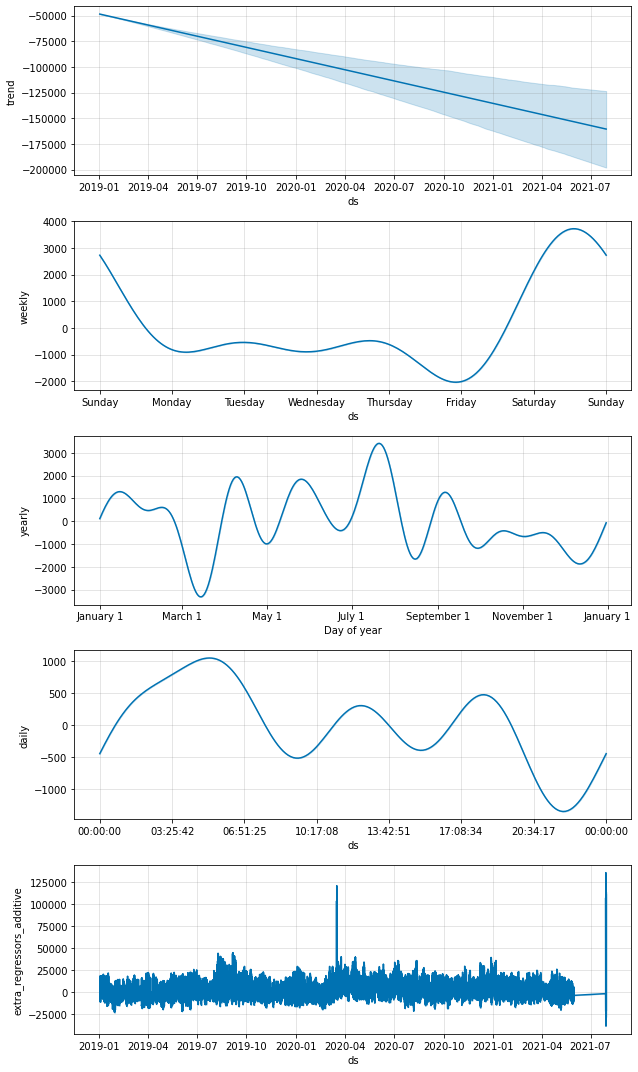

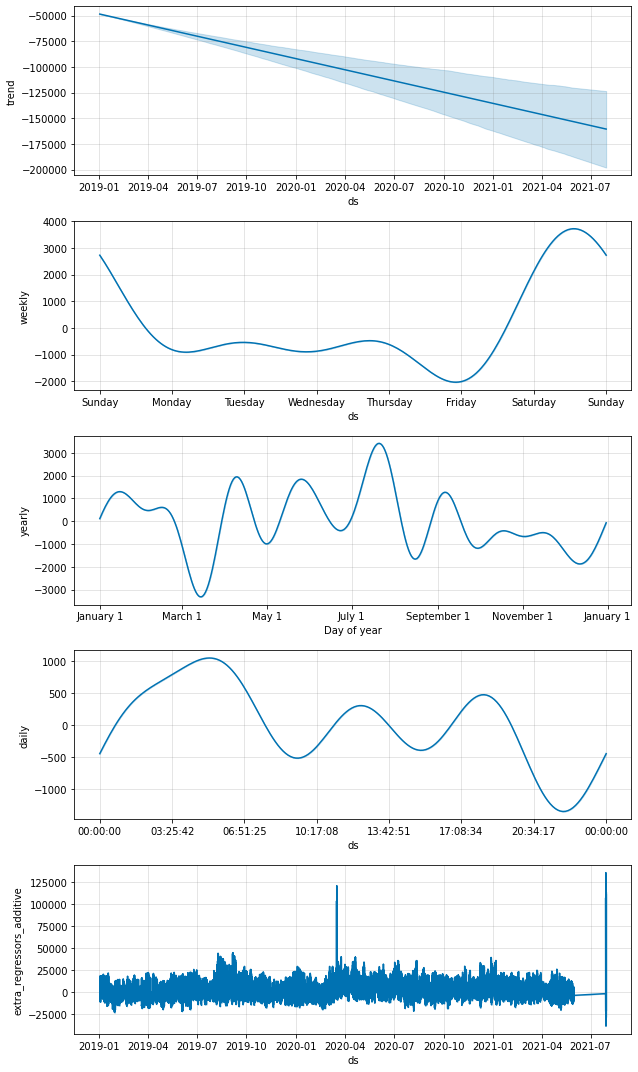

In [31]:
model_fbp.plot_components(forecast)


In [33]:
print("RMSE of Prophet:", np.sqrt(mean_squared_error(data_valid["Cumulative Profit/Loss (C)"], data_valid.Forecast_Prophet)))
print("MAE of Prophet:", mean_absolute_error(data_valid["Cumulative Profit/Loss (C)"], data_valid.Forecast_Prophet))

RMSE of Prophet: 113337.85692687632
MAE of Prophet: 95487.47536244162


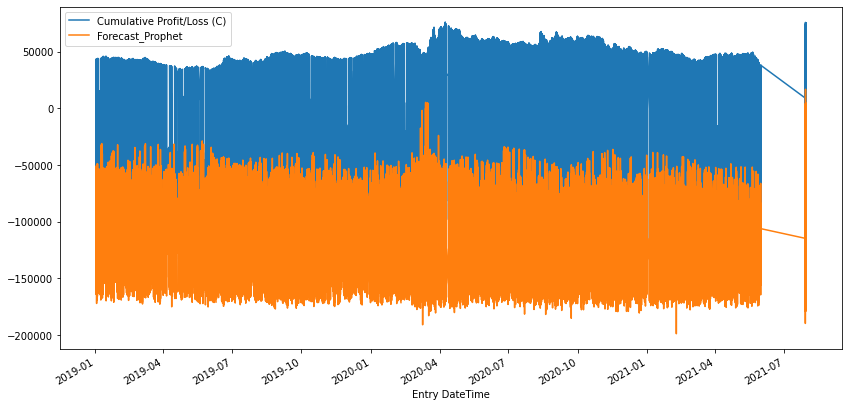

In [34]:
data_valid[["Cumulative Profit/Loss (C)", "Forecast_Prophet"]].plot(figsize=(14, 7))